# Code taken from https://github.com/ngaggion/Chest-xray-landmark-dataset


In [57]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
import re
import random

In [58]:
def preprocess(folderpath, flist):
    try:
        os.mkdir(folderpath)
        print(f"Created directory: {folderpath}")
    except FileExistsError:
        print(f"Directory already exists: {folderpath}")

    for f in flist:
        w, h = 2048, 2048

        try:
            with open(f, "rb") as path:
                dtype = np.dtype(">u2")
                img = np.fromfile(path, dtype=dtype).reshape((h, w))

            # Preprocess the image
            img = 1 - img.astype("float") / 4096
            img = cv2.resize(img, (1024, 1024))
            img = img * 255

            # Ensure the image data is within valid range and type
            img = np.clip(img, 0, 255).astype("uint8")

            p = os.path.join(folderpath, os.path.basename(f).replace(".IMG", ".png"))

            # Write the image and check for success
            if cv2.imwrite(p, img):
                print(f"Saved image to: {p}")
            else:
                print(f"Failed to save image to: {p}")
        except Exception as e:
            print(f"Failed to process file {f}: {e}")

In [2]:
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r"(\d+)", string_)]


img_path = "All247images"
montgomery_path = "Montgomery"

data_root = pathlib.Path(img_path)
all_files = list(data_root.glob("*.IMG"))
all_files = [str(path) for path in all_files]
all_files.sort(key=natural_key)

save_path = "All247imagesPNG/"
# preprocess(save_path, all_files)

In [7]:
def draw_organ(ax, array, color="b"):
    N = array.shape[0]
    for i in range(0, N):
        x, y = array[i, :]
        circ = plt.Circle((x, y), radius=3, color=color, fill=True)
        ax.add_patch(circ)
    return


def draw_lines(ax, array, color="b"):
    N = array.shape[0]
    for i in range(0, N):
        x1, y1 = array[i - 1, :]
        x2, y2 = array[i, :]
        ax.plot([x1, x2], [y1, y2], color=color, linestyle="-", linewidth=1)
    return


def drawOrgans(RL, LL, H=None, RCLA=None, LCLA=None, img=None):
    fig, ax = plt.subplots()

    if img is not None:
        plt.imshow(img, cmap="gray")
    else:
        img = np.zeros([1024, 1024])
        plt.imshow(img)

    plt.axis("off")

    draw_lines(ax, RL, "g")
    draw_lines(ax, LL, "g")

    draw_organ(ax, RL, "g")
    draw_organ(ax, LL, "g")

    if H is not None:
        draw_lines(ax, H, "b")
        draw_organ(ax, H, "b")

    if RCLA is not None:
        draw_lines(ax, RCLA)
        draw_organ(ax, RCLA)

    if RCLA is not None:
        draw_lines(ax, LCLA)
        draw_organ(ax, LCLA)

    return

In [111]:
import os
import pathlib

# Define the data root and gather all files
data_root = pathlib.Path(
    "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247imagesPNG/images"
)
all_files = list(data_root.glob("*.png"))
all_files = [str(path) for path in all_files]
all_files.sort(key=natural_key)

count = 0

# Iterate over all the PNG files
for file in all_files:
    # Generate paths for RL and LL corresponding .npy files
    RL_path = file.replace("\\All247imagesPNG\\images", "/landmarks/RL").replace(".png", ".npy")
    LL_path = file.replace("\\All247imagesPNG\\images", "/landmarks/LL").replace(".png", ".npy")

    # Check if RL and LL files exist
    if not (os.path.exists(RL_path) and os.path.exists(LL_path)):
        # print(f"Removing {file} as one or both of the landmarks are missing.")
        count += 1
        os.remove(file)  # Remove the PNG file if any of the .npy files are missing
    else:
        continue
    
print(f"Removed {count} files.")


Removed 165 files.


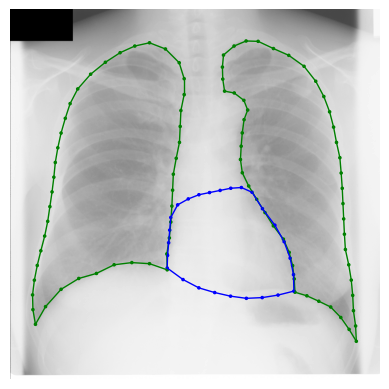

In [144]:
index = random.randint(0, len(all_files))

data_root = pathlib.Path(
    "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247imagesPNG/images"
)
all_files = list(data_root.glob("*.png"))
all_files = [str(path) for path in all_files]
all_files.sort(key=natural_key)

img1 = all_files[index]
RL = img1.replace("\\All247imagesPNG\\images", "/landmarks/RL").replace(".png", ".npy")
LL = img1.replace("\\All247imagesPNG\\images", "/landmarks/LL").replace(".png", ".npy")
H = img1.replace("\\All247imagesPNG\\images", "/landmarks/H").replace(".png", ".npy")

img = cv2.imread(img1, 0)
RL = np.load(RL)
LL = np.load(LL)
H = np.load(H)

drawOrgans(RL, LL, H, img=img)

Text(0.5, 1.0, '(1024, 1024, 1)')

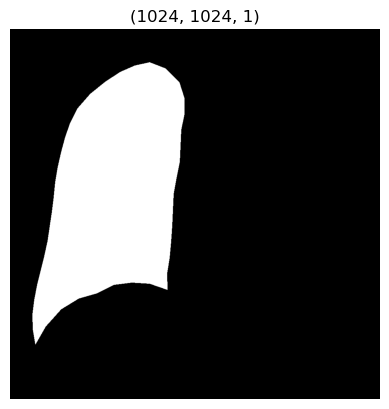

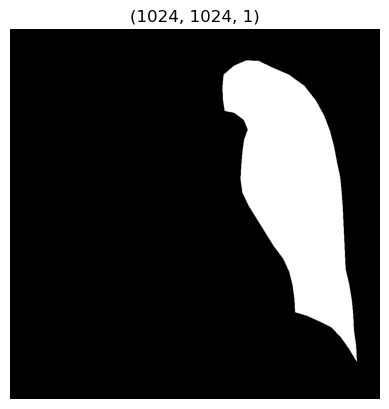

In [145]:
def getDenseMaskRightLungs(RL):
    # Create an RGB image with a red background
    img = np.zeros((1024, 1024, 1), dtype=np.uint8)

    RL = RL.reshape(-1, 1, 2).astype("int")
    img = cv2.drawContours(img, [RL], -1, 1, -1)

    return img


plt.figure()
aux = getDenseMaskRightLungs(RL)
plt.imshow(aux, cmap="gray")
plt.axis(False)
plt.title(aux.shape)


def getDenseMaskLeftLungs(LL):
    # Create an RGB image with a red background
    img = np.zeros((1024, 1024, 1), dtype=np.uint8)

    LL = LL.reshape(-1, 1, 2).astype("int")
    img = cv2.drawContours(img, [LL], -1, 1, -1)

    return img


plt.figure()
aux = getDenseMaskLeftLungs(LL)
plt.imshow(aux, cmap="gray")
plt.axis(False)
plt.title(aux.shape)

Text(0.5, 1.0, '(1024, 1024, 1)')

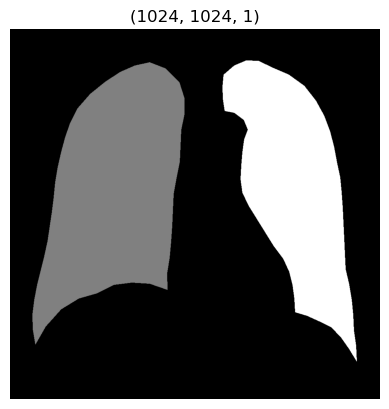

In [146]:
def getDenseMaskLungs(RL, LL):
    img = np.zeros((1024, 1024, 1), dtype=np.uint8)

    RL = RL.reshape(-1, 1, 2).astype("int")
    img = cv2.drawContours(img, [RL], -1, 1, -1)
    
    LL = LL.reshape(-1, 1, 2).astype("int")
    img = cv2.drawContours(img, [LL], -1, 2, -1)

    return img


plt.figure()
aux = getDenseMaskLungs(RL, LL)
plt.imshow(aux, cmap="gray")
plt.axis(False)
plt.title(aux.shape)

In [147]:
print(np.unique(aux))

[0 1 2]


Text(0.5, 1.0, '(1024, 1024, 1)')

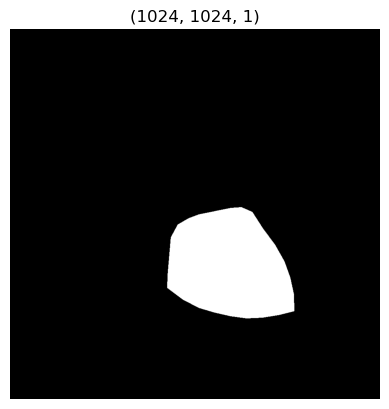

In [148]:
def getDenseMaskHeart(H):
    # Create an RGB image with a red background
    img = np.zeros((1024, 1024, 1), dtype=np.uint8)

    H = H.reshape(-1, 1, 2).astype("int")
    img = cv2.drawContours(img, [H], -1, 1, -1)

    return img


plt.figure()
aux = getDenseMaskHeart(H)
plt.imshow(aux, cmap="gray")
plt.axis(False)
plt.title(aux.shape)


In [149]:
print(np.unique(aux))

[0 1]


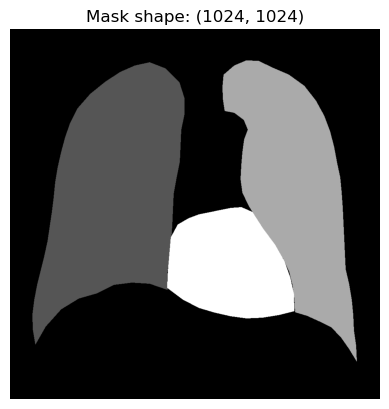

In [150]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def getDenseMask(RL, LL, H):
    # Create a single-channel image for the mask
    mask = np.zeros((1024, 1024), dtype=np.uint8)

    # Reshape the contours
    RL = RL.reshape(-1, 1, 2).astype("int")
    LL = LL.reshape(-1, 1, 2).astype("int")
    H = H.reshape(-1, 1, 2).astype("int")

    # Draw each contour with a unique value
    mask = cv2.drawContours(mask, [RL], -1, 1, -1)  # Right lung with value 1
    mask = cv2.drawContours(mask, [LL], -1, 2, -1)  # Left lung with value 2
    mask = cv2.drawContours(mask, [H], -1, 3, -1)  # Heart with value 3

    return mask


plt.figure()
aux = getDenseMask(RL, LL, H)
plt.imshow(aux, cmap="gray")  # Use 'jet' colormap to visualize different regions
plt.axis("off")
plt.title(f"Mask shape: {aux.shape}")
plt.show()


In [151]:
print(np.unique(aux))

[0 1 2 3]


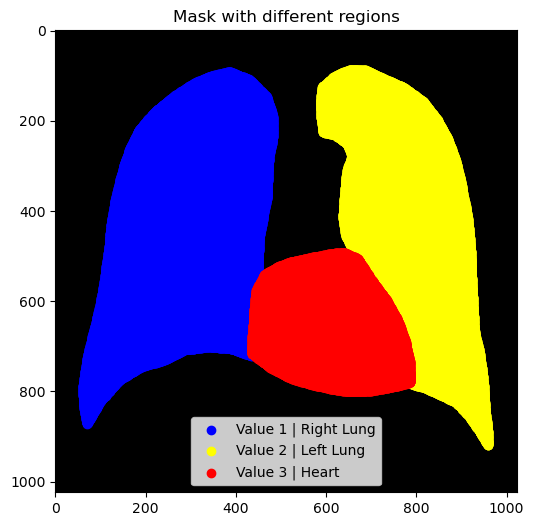

In [152]:
coords_1 = np.column_stack(np.where(aux == 1))
coords_2 = np.column_stack(np.where(aux == 2))
coords_3 = np.column_stack(np.where(aux == 3))

plt.figure(figsize=(6, 6))
plt.imshow(aux, cmap="gray", interpolation="none")
plt.scatter(
    coords_1[:, 1],
    coords_1[:, 0],
    color="blue",
    marker="o",
    label="Value 1 | Right Lung",
)
plt.scatter(
    coords_2[:, 1],
    coords_2[:, 0],
    color="yellow",
    marker="o",
    label="Value 2 | Left Lung",
)
plt.scatter(
    coords_3[:, 1], coords_3[:, 0], color="red", marker="o", label="Value 3 | Heart"
)
plt.legend()
plt.title("Mask with different regions")
plt.show()

In [153]:
def process_and_save_images(
    input_folder,
    output_folder,
    # heart_folder="heart",
    lungs_folder="lungs",
):
    data_root = pathlib.Path(input_folder)
    all_files = list(data_root.glob("*.png"))
    all_files = [str(path) for path in all_files]
    all_files.sort(key=natural_key)

    # heart_output_path = os.path.join(output_folder, heart_folder)
    lungs_output_path = os.path.join(output_folder, lungs_folder)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # if not os.path.exists(heart_output_path):
        # os.makedirs(heart_output_path)
    if not os.path.exists(lungs_output_path):
        os.makedirs(lungs_output_path)

    for file_path in all_files:
        file_name = os.path.basename(file_path)

        RL_path = file_path.replace(
            "\\All247imagesPNG\\images", "/landmarks/RL"
        ).replace(".png", ".npy")
        LL_path = file_path.replace(
            "\\All247imagesPNG\\images", "/landmarks/LL"
        ).replace(".png", ".npy")
        # H_path = file_path.replace("\\All247imagesPNG\\images", "/landmarks/H").replace(
        #     ".png", ".npy"
        # )

        RL = np.load(RL_path)
        LL = np.load(LL_path)
        # H = np.load(H_path)

        lungs_mask = getDenseMaskLungs(RL, LL)
        # heart_mask = getDenseMaskHeart(H)

        # heart_path = os.path.join(heart_output_path, file_name)
        lungs_path = os.path.join(lungs_output_path, file_name)

        # cv2.imwrite(heart_path, heart_mask)
        cv2.imwrite(lungs_path, lungs_mask)

        print(f"Saved masked image to: {lungs_path}")

In [155]:
input_folder = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247imagesPNG/images"
output_folder = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/"

process_and_save_images(input_folder, output_folder)

Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0004_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0005_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0008_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0010_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0018_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0019_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0021_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0023_0.png
Saved masked image to: C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247masks/lungs\CHNCXR_0026_0.png
Saved masked image to: C:/Users/DryLab/Desktop

## Preprocessed Montgomery dataset

In [38]:
# img_path = r"C:\Users\DryLab\Desktop\ViLLA\RPN_MIMIC\images\Montgomery\images\images"
# img_path = r"C:\Users\DryLab\Desktop\ViLLA\RPN_MIMIC\images\Shenzhen\images\images"
# img_path = "Padchest/Images/"
img_path = r"C:\Users\DryLab\Desktop\ViLLA\RPN_MIMIC\images\All247imagesPNG\x-ray"

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r"(\d+)", string_)]

data_root = pathlib.Path(img_path)
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

save_img = r"C:\Users\DryLab\Desktop\ViLLA\RPN_MIMIC\images\All247imagesPNG"

In [39]:
i = 1

for file in all_files:
    print('File', i, 'of', len(all_files))

    img = cv2.imread(file, 0)

    gray = 255*(img > 1) # To invert the text to white
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)

    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    cropimg = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image

    shape = cropimg.shape

    if shape[0] < shape[1]:
        pad = (shape[1] - shape[0])    
        
        if pad % 2 == 1:
            pad = pad // 2
            pad_y = [pad, pad+1]
        else:
            pad = pad // 2
            pad_y = [pad, pad]
            
        pad_x = [0, 0]
    elif shape[1] < shape[0]:
        pad = (shape[0] - shape[1]) 
        
        if pad % 2 == 1:
            pad = pad // 2
            pad_x = [pad, pad+1]
        else:
            pad = pad // 2
            pad_x = [pad, pad]
            
        pad_y = [0, 0]
    elif shape[0] == shape[1]:
        pad_x = [0, 0]
        pad_y = [0, 0]

    img = np.pad(cropimg, pad_width = [pad_y, pad_x])    

    if img.shape[0] != img.shape[1]:
        print('Error padding image')
        break

    img_ = cv2.resize(img, [1024, 1024])
    
    cv2.imwrite(file.replace(img_path, save_img), img_)

    i = i+1

File 1 of 704
File 2 of 704
File 3 of 704
File 4 of 704
File 5 of 704
File 6 of 704
File 7 of 704
File 8 of 704
File 9 of 704
File 10 of 704
File 11 of 704
File 12 of 704
File 13 of 704
File 14 of 704
File 15 of 704
File 16 of 704
File 17 of 704
File 18 of 704
File 19 of 704
File 20 of 704
File 21 of 704
File 22 of 704
File 23 of 704
File 24 of 704
File 25 of 704
File 26 of 704
File 27 of 704
File 28 of 704
File 29 of 704
File 30 of 704
File 31 of 704
File 32 of 704
File 33 of 704
File 34 of 704
File 35 of 704
File 36 of 704
File 37 of 704
File 38 of 704
File 39 of 704
File 40 of 704
File 41 of 704
File 42 of 704
File 43 of 704
File 44 of 704
File 45 of 704
File 46 of 704
File 47 of 704
File 48 of 704
File 49 of 704
File 50 of 704
File 51 of 704
File 52 of 704
File 53 of 704
File 54 of 704
File 55 of 704
File 56 of 704
File 57 of 704
File 58 of 704
File 59 of 704
File 60 of 704
File 61 of 704
File 62 of 704
File 63 of 704
File 64 of 704
File 65 of 704
File 66 of 704
File 67 of 704
File

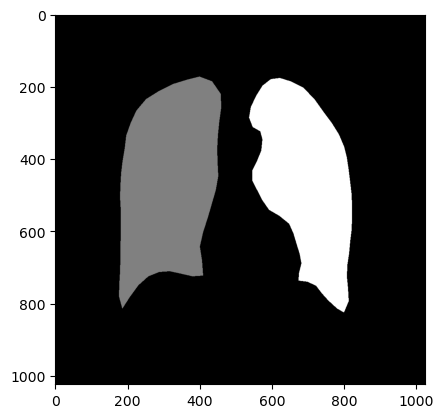

In [156]:
JSRT_mask_path = r"C:\Users\DryLab\Desktop\ViLLA\RPN_MIMIC\images\All247masks\lungs"

JSRT_mask = os.listdir(JSRT_mask_path)

first_mask = cv2.imread(os.path.join(JSRT_mask_path, JSRT_mask[1]), 0)

plt.imshow(first_mask, cmap="gray")

In [157]:
# first_mask = first_mask.astype(np.float32) / 255.0

In [158]:
print(np.unique(first_mask))

[0 1 2]


## Pair image mask

In [44]:
import os

image_path = r"C:\Users\DryLab\Downloads\Lung X-ray\data\Lung Segmentation\CXR_png"
mask_path = r"C:\Users\DryLab\Downloads\Lung X-ray\data\Lung Segmentation\masks"

In [4]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [16]:
check[0]

'CHNCXR_0001_0_mask'

In [18]:
for i in mask:
    if "mask" in i:
      # Rename the file to remove the mask
      os.rename(os.path.join(mask_path, i+".png"), os.path.join(mask_path, i.split("_mask")[0]))

In [29]:
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]

In [30]:
import pandas as pd

df = pd.DataFrame({"image":image_file_name, "mask":mask})

In [31]:
df.iloc[0]

image    CHNCXR_0001_0
mask     CHNCXR_0001_0
Name: 0, dtype: object

In [32]:
df

,image,mask
0,CHNCXR_0001_0,CHNCXR_0001_0
1,CHNCXR_0002_0,CHNCXR_0002_0
2,CHNCXR_0003_0,CHNCXR_0003_0
3,CHNCXR_0004_0,CHNCXR_0004_0
4,CHNCXR_0005_0,CHNCXR_0005_0
...,...,...
699,MCUCXR_0383_1,MCUCXR_0383_1
700,MCUCXR_0387_1,MCUCXR_0387_1
701,MCUCXR_0390_1,MCUCXR_0390_1
702,MCUCXR_0393_1,MCUCXR_0393_1


In [33]:
# Check the 96 image that doesn't have mask
images = os.listdir(image_path)
mask = os.listdir(mask_path)

image_file_name = [fName.split(".png")[0] for fName in images]
mask_file_name = [fName.split(".png")[0] for fName in mask]

no_mask = [i for i in image_file_name if i not in mask_file_name]
print("Total image that doesn't have mask:",len(no_mask))

no_mask

Total image that doesn't have mask: 96


['CHNCXR_0025_0',
 'CHNCXR_0036_0',
 'CHNCXR_0037_0',
 'CHNCXR_0038_0',
 'CHNCXR_0039_0',
 'CHNCXR_0040_0',
 'CHNCXR_0065_0',
 'CHNCXR_0181_0',
 'CHNCXR_0182_0',
 'CHNCXR_0183_0',
 'CHNCXR_0184_0',
 'CHNCXR_0185_0',
 'CHNCXR_0186_0',
 'CHNCXR_0187_0',
 'CHNCXR_0188_0',
 'CHNCXR_0189_0',
 'CHNCXR_0190_0',
 'CHNCXR_0191_0',
 'CHNCXR_0192_0',
 'CHNCXR_0193_0',
 'CHNCXR_0194_0',
 'CHNCXR_0195_0',
 'CHNCXR_0196_0',
 'CHNCXR_0197_0',
 'CHNCXR_0198_0',
 'CHNCXR_0199_0',
 'CHNCXR_0200_0',
 'CHNCXR_0201_0',
 'CHNCXR_0202_0',
 'CHNCXR_0203_0',
 'CHNCXR_0204_0',
 'CHNCXR_0205_0',
 'CHNCXR_0206_0',
 'CHNCXR_0207_0',
 'CHNCXR_0208_0',
 'CHNCXR_0209_0',
 'CHNCXR_0210_0',
 'CHNCXR_0211_0',
 'CHNCXR_0212_0',
 'CHNCXR_0213_0',
 'CHNCXR_0214_0',
 'CHNCXR_0215_0',
 'CHNCXR_0216_0',
 'CHNCXR_0217_0',
 'CHNCXR_0218_0',
 'CHNCXR_0219_0',
 'CHNCXR_0220_0',
 'CHNCXR_0336_1',
 'CHNCXR_0341_1',
 'CHNCXR_0342_1',
 'CHNCXR_0343_1',
 'CHNCXR_0344_1',
 'CHNCXR_0345_1',
 'CHNCXR_0346_1',
 'CHNCXR_0347_1',
 'CHNCXR_0

In [34]:
# Delete the image that doesn't have mask
for i in no_mask:
    os.remove(os.path.join(image_path, i+".png"))